<a href="https://colab.research.google.com/github/ahmadelhelbawy/frontend/blob/main/cookbooks/video_understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Video Understanding with Qwen3-VL

In this notebook, we delve into the capabilities of the **Qwen3-VL** model for video understanding tasks. Our objective is to showcase how this advanced model can be applied to various video analysis scenarios.


#### \[Setup\]

We start by loading the pre-trained `Qwen3-VL` model.

In [49]:
from openai import OpenAI
import os, warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")

os.environ["OPENROUTER_API_KEY"] = "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"

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["OPENROUTER_API_KEY"]
)

DASH_MODEL_ID = "qwen/qwen3-vl-235b-a22b-instruct"
print("✅ Connected to OpenRouter | Using hosted model:", DASH_MODEL_ID)

✅ Connected to OpenRouter | Using hosted model: qwen/qwen3-vl-235b-a22b-instruct


Load video frames and timestamps

In [50]:
import os
import math
import hashlib
import requests

from IPython.display import Markdown, display
import numpy as np
from PIL import Image
import decord
from decord import VideoReader, cpu


def download_video(url, dest_path):
    response = requests.get(url, stream=True)
    with open(dest_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8096):
            f.write(chunk)
    print(f"Video downloaded to {dest_path}")


def get_video_frames(video_path, num_frames=128, cache_dir='.cache'):
    os.makedirs(cache_dir, exist_ok=True)

    video_hash = hashlib.md5(video_path.encode('utf-8')).hexdigest()
    if video_path.startswith('http://') or video_path.startswith('https://'):
        video_file_path = os.path.join(cache_dir, f'{video_hash}.mp4')
        if not os.path.exists(video_file_path):
            download_video(video_path, video_file_path)
    else:
        video_file_path = video_path

    frames_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_frames.npy')
    timestamps_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_timestamps.npy')

    if os.path.exists(frames_cache_file) and os.path.exists(timestamps_cache_file):
        frames = np.load(frames_cache_file)
        timestamps = np.load(timestamps_cache_file)
        return video_file_path, frames, timestamps

    vr = VideoReader(video_file_path, ctx=cpu(0))
    total_frames = len(vr)

    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    frames = vr.get_batch(indices).asnumpy()
    timestamps = np.array([vr.get_frame_timestamp(idx) for idx in indices])

    np.save(frames_cache_file, frames)
    np.save(timestamps_cache_file, timestamps)

    return video_file_path, frames, timestamps


def create_image_grid(images, num_columns=8):
    pil_images = [Image.fromarray(image) for image in images]
    num_rows = math.ceil(len(images) / num_columns)

    img_width, img_height = pil_images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image


In [51]:
pip install decord

Inference function

In [52]:
def inference(video, prompt, max_new_tokens=2048, total_pixels=20480 * 32 * 32, min_pixels=64 * 32 * 32, max_frames= 2048, sample_fps = 2):
    """
    Perform multimodal inference on input video and text prompt using the OpenAI compatible API client.

    Args:
        video (str): Path or URL to a video file.
        prompt (str): User text prompt to guide the model's generation.
        max_new_tokens (int, optional): Maximum number of tokens to generate. Default is 2048.
        # Note: total_pixels, min_pixels, max_frames, and sample_fps are not directly used
        # by the OpenAI compatible API, but kept for function signature compatibility
        # if you were to switch back to a local model that uses them.
        total_pixels (int, optional): Not used in API inference. Default is 20480*32*32.
        min_pixels (int, optional): Not used in API inference. Default is 16*32*32.
        max_frames (int, optional): Not used in API inference. Default is 2048.
        sample_fps (int, optional): Not used in API inference. Default is 2.


    Returns:
        str: Generated text response from the model.

    Notes:
        - This function now uses the 'client' object for making API calls.
        - Video input is expected to be a single video file path or URL.
    """

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "video_url", "video_url": {"url": video}},
                {"type": "text", "text": prompt},
            ]
        }
    ]

    try:
        completion = client.chat.completions.create(
            model=DASH_MODEL_ID, # Use the model ID defined in the setup
            messages=messages,
            max_tokens=max_new_tokens # Use max_tokens for API
        )
        return completion.choices[0].message.content
    except Exception as e:
        print(f"API Error during inference: {e}")
        return f"Error: {e}"

Inference function with API using OpenAI and Dashscope SDK.

**Important Notice:**
- Video input is limited to 1 GB maximum file size.
- When using frame list format: 4–512 frames required (support for more frames coming soon).

In [53]:
import os
from openai import OpenAI
from IPython.display import Markdown, display


def inference_with_openai_api(
    video,
    prompt,
    model_id = DASH_MODEL_ID,
    video_type='url'
):
    if video_type=='url':
        video_msg = {"type": "video_url", "video_url": {"url": video}}
    elif video_type=='frame_list':
        video_msg = {"type": "video", "video": video['frame_list']}

    client = OpenAI(
        api_key = os.getenv('DASHSCOPE_API_KEY'),
        base_url = os.getenv('OPENAI_BASE_HTTP_API_URL'),
    )
    messages = [
        {
            "role": "user",
            "content": [
                video_msg,
                {"type": "text", "text": prompt},
            ]
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
    )
    print(completion)
    return completion.choices[0].message.content


def inference_with_dashscope_api(
    video,
    prompt,
    model_id = DASH_MODEL_ID,
    video_type='url'
):
    if video_type=='url':
        video_msg = {"video": video}
    elif video_type=='frame_list':
        video_msg = {"video": video['frame_list'], 'fps': video['fps'] }

    messages = [
        {
            "role": "user",
            "content": [
                video_msg,
                {"text": prompt},
            ]
        }
    ]
    completion = dashscope.MultiModalConversation.call(
        api_key=os.getenv("DASHSCOPE_API_KEY"),
        model=model_id,
        messages=messages
    )
    print(completion)
    return completion["output"]["choices"][0]["message"].content[0]["text"]

####  \[Usage\]

Once the model is loaded (or the API is ready), you can provide video inputs in **two formats**:

1. **Video URL (`video_url`)** — A file path or publicly accessible HTTP(S) URL pointing to a video file (e.g., MP4, AVI).  
   ✅ Best for quick prototyping or when you want the model/API to handle video decoding internally.
2. **Frame List (`frame_list`)** — A list of PIL Image objects or file paths representing sampled frames from a video.  
   ✅ Best for fine-grained control, preprocessing, or when you’ve already decoded the video.


### 1. Using Video URL - Local Inference

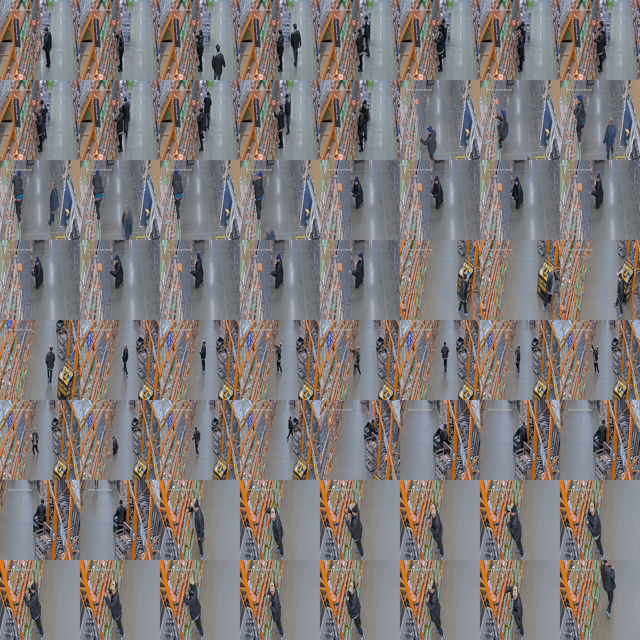

Behavior classification result:


{
  "label": "Normal",
  "reason": "No suspicious or stealing activity detected."
}

In [54]:
### 1. Local Inference — Using Video URL (Shoplifting Demo)
video_path = "/content/shoplifting_11.mp4" # Using the uploaded file

prompt = """
You are an intelligent retail security model.
Your goal is NOT to summarize the whole video, but to DETECT any abnormal or suspicious behavior in the shop.

Analyze the entire sequence carefully and do the following:

1. Identify if there is any moment or person showing:
   - Suspicious actions (hiding items, nervous gestures, lingering near shelves)
   - Stealing actions (taking without paying, concealing, or exiting quickly)

2. If no anomaly is found, respond:
   {"label": "Normal", "reason": "No suspicious or stealing activity detected."}

3. If any anomaly is detected, return structured data in this exact JSON format:
{
  "label": "<Suspicious|Stealing>",
  "reason": "<brief explanation of the action>",
  "time_segments": [
    {"start_sec": <approx_start_time>, "end_sec": <approx_end_time>},
    {"start_sec": <...>, "end_sec": <...>}
  ],
  "bounding_boxes": [
    {"frame_index": <int>, "description": "<person concealing item>", "box": [x1, y1, x2, y2]},
    {"frame_index": <int>, "description": "<abnormal behavior>", "box": [x1, y1, x2, y2]}
  ]
}

Focus on anomaly recognition, not overall behavior.
Return only JSON — no extra explanation or text.
"""

# Extract frames from video for visualization
video_path, frames, timestamps = get_video_frames(video_path, num_frames=64)
image_grid = create_image_grid(frames, num_columns=8)
display(image_grid.resize((640, 640)))

# Run inference (this function must use your new OpenRouter client internally)
response = inference(video_path, prompt)
print("Behavior classification result:")
display(Markdown(response))

### 2. Using Video URL - API Inference

In [55]:
import os
from openai import OpenAI
from IPython.display import Markdown, display
import base64


def run_shoplifting_inference(video_path, prompt):
    with open(video_path, "rb") as f:
        video_bytes = f.read()
        video_b64 = base64.b64encode(video_bytes).decode()

    try:
        response = client.chat.completions.create(
            model=DASH_MODEL_ID,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {
                            "type": "input_audio", # This should be "video" not "input_audio"
                            "input_audio": { # This should be "video" not "input_audio"
                                "data": video_b64,
                                "mime_type": "video/mp4"
                            }
                        }
                    ]
                }
            ],
        )

        result = response.choices[0].message.content
        print("Inference completed.")
        display(Markdown(result))

    except Exception as e:
        print("Error:", e)
        print("If video upload fails, we can switch to frame-based inference.")

In [56]:
# Run the shoplifting inference with the uploaded video
run_shoplifting_inference(video_path, prompt)

Error: <!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Temporarily unavailable | openrouter.ai | Cloudflare</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/cf.errors.css" />
<!--[if lt IE 9]><link rel="stylesheet" id='cf_styles-ie-css' href="/cdn-cgi/styles/cf.errors.ie.css" /><![endif]-->
<style>body{margin:0;padding:0}</style>


<!--[if gte IE 10]><!-->
<script>
  if (!navigator.cookieEnabled) {
    window.addEventLis

In [57]:
!pip install decord

In [58]:
from google.colab import files
uploaded = files.upload()

Saving shoplifting_11.mp4 to shoplifting_11 (1).mp4


In [59]:
### 1. Local Inference — Shoplifting Behavior Classification
# Replace with your own test video file or URL
video_path = "/content/shoplifting_12.mp4"  # Using the uploaded file

prompt = """
You are a store surveillance analysis model.
Given a video showing activity inside a retail shop, classify the dominant human behavior as one of:
- Normal  (people browsing, paying, moving naturally)
- Suspicious  (lingering, hiding items, abnormal gestures)
- Stealing  (taking items without paying, concealing and leaving)

Return your answer strictly in JSON format:
{"label": "<Normal|Suspicious|Stealing>", "reason": "<one short explanation>"}
"""

# Commenting out local inference with get_video_frames as it's not working
# video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

# Running API inference with the uploaded video
# response = inference(video_path, prompt)
# print("Behavior classification result:")
# display(Markdown(response))

### 3. Using Frame List — Local Inference

In [60]:
## 3. API Inference — Using Video URL  Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# Base URL for pre-extracted video frames (public OSS bucket)
video_frame_dir = 'https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/demo_cooking'

# Configure sampling: e.g., 0.25 FPS = 1 frame per 4 seconds
sample_fps=0.25 # or =1

# The maximum number of pixels expected to be used from the video — adjustable based on available GPU memory. Our model natively supports up to 256K input tokens.
total_pixels=24*1024*32*32   # or 256*1024*32*32

video_frame_list = [f"{video_frame_dir}/{i}.000.jpg" for i in range(0, 1228, int(1/sample_fps))]
prompt = "Briefly describe the video."
response = inference(video_frame_list, prompt, sample_fps=sample_fps, total_pixels=total_pixels)
display(Markdown(response))

I can’t describe a video since I don’t have access to visual content or video files. If you can share details like the title, scene, or key moments, I’d be happy to help summarize or analyze it!

### 4. Using Frame List — API Inference

In [ ]:
## 4. API Inference — Using Video URL  Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
video_frame_list = [f"https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/validation_Math_6/{i}.000.jpg" for i in range(0, 302, 2)]

video = {
        'frame_list':video_frame_list,
        'fps': '0.5'
    }
# fps
prompt = "Describe this video."

response = inference_with_dashscope_api(video, prompt, video_type='frame_list')
display(Markdown(response))

### 5. Using Interleaved Timestamp-Image Pairs — API Inference

- In the following section, we will demonstrate, through a spatial-temporal grounding example, how to call the API for inference by using interleaved timestamp-image pairs as input.

In [ ]:
# Use the uploaded video path
video_path = "/content/shoplifting_12.mp4"

# Extract frames and timestamps from the video
# We'll use a smaller number of frames for this example
video_file_path, frames, timestamps = get_video_frames(video_path, num_frames=16) # Reduced frames for example

# Prepare messages with interleaved timestamps and image URLs
messages = []
for i, (frame, timestamp) in enumerate(zip(frames, timestamps)):
    # Save the frame temporarily to get a URL or base64
    # For this example, we'll convert to base64 directly for the API call
    from PIL import Image
    import base64
    from io import BytesIO

    pil_img = Image.fromarray(frame)
    buffered = BytesIO()
    pil_img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()

    messages.append(
        {
            "type": "text",
            "text": f"<{timestamp[0]:.1f} seconds>"
        }
    )
    messages.append(
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{img_str}"
            }
        }
    )

# Add the prompt for spatial-temporal grounding
prompt = """
Analyze the video frames provided with timestamps.
Identify any instances of suspicious behavior related to potential shoplifting,
such as lingering near merchandise, looking around nervously, or interacting with items in an unusual way.
For each frame where suspicious behavior is observed, provide the timestamp and
the bounding box coordinates [x_min, y_min, x_max, y_max] of the person exhibiting the behavior.
If no suspicious behavior is detected in a frame, skip that frame.
Return the results in a JSON array format:
[{"time": <timestamp>, "bbox_2d": [x_min, y_min, x_max, y_max], "label": "suspicious behavior"}, ...]
"""

messages.append({"type": "text", "text": prompt})

# The final messages list is now ready for the API call
# The actual API call will be in the next relevant cell

In [ ]:
import os
from openai import OpenAI


def inference_with_openai_api(
    model_id = DASH_MODEL_ID,
    messages = None # Use the messages prepared in the previous cell
):
    # Use the globally defined client for OpenRouter
    if 'client' not in globals() or not isinstance(client, OpenAI):
         raise RuntimeError("OpenAI client not initialized. Please run the setup cell.")

    completion = client.chat.completions.create(
        model=model_id,
        messages=messages, # Use the messages prepared in the previous cell
        # seed=125, # Seed is not a standard parameter for all models/APIs
    )
    return completion.choices[0].message.content

In [ ]:
import json
import markdown
from bs4 import BeautifulSoup
from datetime import datetime
import math
from PIL import Image, ImageDraw
from io import BytesIO
import requests


# draw bbox on image
def draw_bbox(image, bbox):
    draw = ImageDraw.Draw(image)
    draw.rectangle(bbox, outline='red', width=4)
    return image


def create_image_grid_pil(pil_images, num_columns=8):
    num_rows = math.ceil(len(pil_images) / num_columns)

    img_width, img_height = pil_images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image


def parse_json(response):
    html = markdown.markdown(response, extensions=['fenced_code'])
    soup = BeautifulSoup(html, 'html.parser')
    json_text = soup.find('code').text

    data = json.loads(json_text)
    return data


In [ ]:
response = inference_with_openai_api(messages=messages)
results = parse_json(response)

vis_images = []
for content_idx, content in enumerate(messages[0]['content']):
    matched_result = None
    if content['type'] == 'text' and "seconds>" in content['text']:
        for result in results:
            time_str = str(result['time'])
            if time_str in content['text']:
                matched_result = result

        image_url = messages[0]['content'][content_idx + 1]['image_url']['url']
        image = Image.open(BytesIO(requests.get(image_url).content))

        if matched_result is not None:
            image_width, image_height = image.size
            x_min, y_min, x_max, y_max = matched_result['bbox_2d']
            x_min = x_min / 1000 * image_width
            y_min = y_min / 1000 * image_height
            x_max = x_max / 1000 * image_width
            y_max = y_max / 1000 * image_height
            image = draw_bbox(image, [x_min, y_min, x_max, y_max])
            vis_images.append(image)
        else:
            vis_images.append(image)


image_grid = create_image_grid_pil(vis_images, num_columns=2)
display(image_grid.resize((640, 960)))
